In [ ]:
import csv
import configparser

In [ ]:
# Functions
def read_megares_v2_ontology(config):
    # Create ontology dictionary from MEGARes ontology file
    megares_ontology = dict()
    hierarchy_dict = dict()
    with open(config['DATABASE']['MEGARES_ONTOLOGY'], 'r') as ontology_tsv:
        ontology_reader = csv.reader(ontology_tsv)
        for row in ontology_reader:
            # Skip column names
            if row[0] == "header":
                continue

            typ = row[1]
            cl = row[2]
            mech = row[3]
            group = row[4]

            # Set up hiearachy dict. This will be our tree structure
            if not typ in hierarchy_dict:
                hierarchy_dict[typ] = {}

            if not cl in hierarchy_dict[typ]:
                hierarchy_dict[typ][cl] = {}

            if not mech in hierarchy_dict[typ][cl]:
                hierarchy_dict[typ][cl][mech] = []

            if not group in hierarchy_dict[typ][cl][mech]:
                hierarchy_dict[typ][cl][mech].append(group)

            # FIll in our dict
            megares_ontology[row[0]] = {"class": cl,
                                        "mechanism": mech,
                                        "group": group,
                                        "type": typ
                                        }
    return megares_ontology, hierarchy_dict

In [ ]:
def get_resistome(config, sample_name):
    return sample_name + ".fastq" + config['EXTENSION']['DEDUPLICATED'] + "_" + config['MISC']['RESISTOME_STRATEGY'] + config['EXTENSION']['RESISTOME_DIVERSITY']

def get_reads_length(config, sample_name):
    return sample_name + ".fastq" + config['EXTENSION']['READS_LENGTH']

In [ ]:
# Get info from snakemake
samples_list = snakemake.params[0]
config_file = snakemake.input[2]
config = configparser.ConfigParser()
config.read(config_file)
output_plot = snakemake.output[0]

In [50]:
# Megares hierarchy
megares_ontology, hierarchy_dict = read_megares_v2_ontology(config)

In [57]:
# Read resistomes

type_samples = dict()
class_samples = dict()
mech_samples = dict()
group_samples = dict()

represented_hierarchy = dict()

for gene, ontology in megares_ontology.items():
    type_samples[ontology['type']] = set()
    class_samples[ontology['class']] = set()
    mech_samples[ontology['mechanism']] = set()
    group_samples[ontology['group']] = set()

for sample in samples_list:
    with open(get_resistome(config, sample)) as resistome_file:
        resistome_reader = csv.reader(resistome_file)
        for row in resistome_reader:
            # Remove statistics and headers
            if (row[0] == 'Statistics') or (row[0] == 'Resistome') or ('ARG_' in row[0]) or (row[0] == 'MEGARes Gene Header'):
                continue

            gene_acc = row[0]
            gene_acc_hits = row[1]
            gene_type = megares_ontology[gene_acc]['type']
            gene_class = megares_ontology[gene_acc]['class']
            gene_mechanism = megares_ontology[gene_acc]['mechanism']
            gene_group = megares_ontology[gene_acc]['group']

            metals_or_biocides = 'Metals' in gene_acc or 'Biocides' in gene_acc or 'biocide' in gene_acc or 'metal' in gene_acc
            if metals_or_biocides:
                continue

            if 'RequiresSNPConfirmation' in gene_acc:
                continue

            type_samples[gene_type].add(sample)
            class_samples[gene_class].add(sample)
            mech_samples[gene_mechanism].add(sample)
            group_samples[gene_group].add(sample)

            if gene_type not in represented_hierarchy:
                represented_hierarchy[gene_type] = dict()

            if gene_class not in represented_hierarchy[gene_type]:
                represented_hierarchy[gene_type][gene_class] = dict()

            if gene_mechanism not in represented_hierarchy[gene_type][gene_class]:
                represented_hierarchy[gene_type][gene_class][gene_mechanism] = []

In [59]:
#Categories for x axis are just samples
bovine_sample_names = ['BOVINE_FECAL_TELS_I', 'BOVINE_FECAL_TELS_II', 'BOVINE_FECAL_PB', 'ILL_BOV']
human_sample_names = ['HUMAN_FECAL_TELS_II', 'HUMAN_FECAL_PB', 'ILL_HU']
soil_sample_names = ['SOIL_TELS_II', 'SOIL_PB', 'ILL_SO']
mock_sample_names = ['MOCK_TELS', 'MOCK_GRIDION', 'MOCK_PROMETHION']

#Categories for y axis are mechanisms 
mechtick_vals = []
mechtick_text = []
classtick_vals = []
classtick_text = []
left = 0
right = 0
mech_names = []
for typ in represented_hierarchy:
    for cl in represented_hierarchy[typ]:
        left = len(mech_names)
        right = left + len(represented_hierarchy[typ][cl])
        classtick_pos = (right + left - 1) / 2.0
        classtick_vals.append(classtick_pos)
        classtick_text.append(cl)
        i = left + 1
        for mech in represented_hierarchy[typ][cl]:
            current_tick_pos = (left + i - 1) / 2.0
            mechtick_vals.append(current_tick_pos)
            mechtick_text.append(mech)

            mech_names.append(mech)
            i += 1
            left += 1

label_heatmap_matrix = []
i = 1
for typ in represented_hierarchy:
    for cl in represented_hierarchy[typ]:
        val = (i / float(len(mech_names) + 1)) 
        for mech in represented_hierarchy[typ][cl]:
            label_heatmap_matrix.append([val])
        i+=1

j = 1
samples_presence_matrix = []
for typ in represented_hierarchy:
    for cl in represented_hierarchy[typ]:
        val = j / float(len(mech_names) + 1)
        for mech in represented_hierarchy[typ][cl]:
            sample_presence_matrix_row = [0 for x in range(0, len(samples_list))]
            for i in range(0, len(sample_presence_matrix_row)):
                if samples_list[i] in mech_samples[mech]:
                    sample_presence_matrix_row[i] = val
            samples_presence_matrix.append(sample_presence_matrix_row)
        j+=1

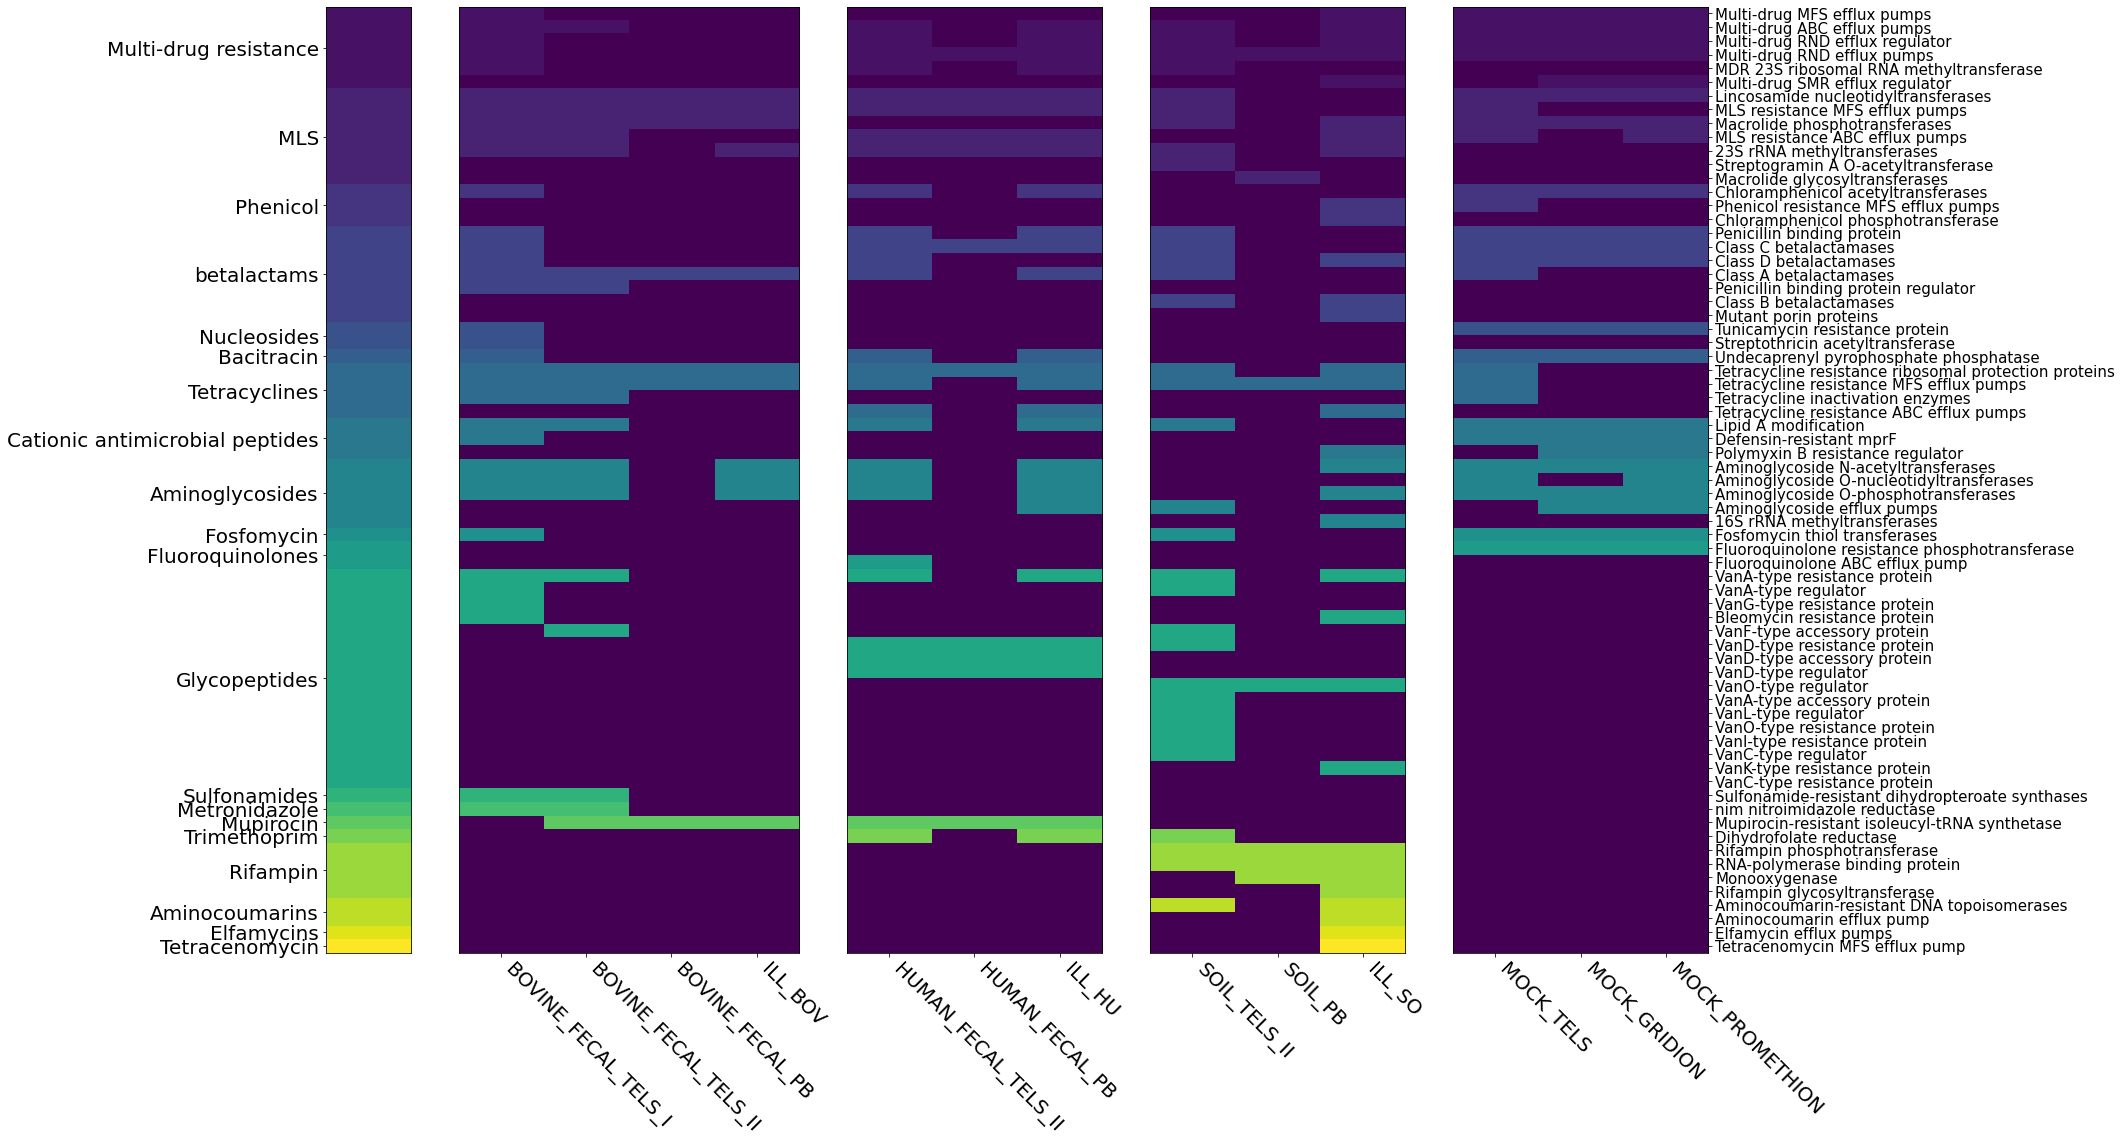

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

custom_color_list = ["grey", "lightpink", "palegreen", "peachpuff", "powderblue", "plum",
                     "lightsalmon", "burlywood", "tomato", "chocolate", "gold", "salmon",
                     "orchid"]
n_bins = len(classtick_text)
custom_color = LinearSegmentedColormap.from_list('custom', custom_color_list, N=n_bins)

color_max = np.max(label_heatmap_matrix)
color_min = 0


fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, len(samples_list)]}, figsize=(32, 18))
axs[0].imshow(label_heatmap_matrix, aspect='auto', vmin=color_min, vmax=color_max)#,  cmap=custom_color)
axs[1].imshow(samples_presence_matrix, aspect='auto', vmin=color_min, vmax=color_max)#, cmap=custom_color)

# Use the pyplot interface to change just one subplot...
plt.sca(axs[0])
plt.yticks(classtick_vals, classtick_text, color='black', fontsize=20)
plt.xticks([], [], color='black')

plt.sca(axs[1])
plt.xticks([i for i in range(len(samples_list))], samples_list, color='black', rotation=-45, ha="left", fontsize=20)
plt.yticks(mechtick_vals, mechtick_text, color='black')
plt.tick_params(axis='y', labelleft=False, labelright=True, left=False, right=True, labelsize=15)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15, right=0.75)
plt.savefig('heatmap_all_samples.pdf')